# Data Preprocessing for Electric Load Forecasting

This notebook demonstrates a production-style data preprocessing pipeline for electric load forecasting. We combine electricity demand and weather data for ten major U.S. cities, ensuring robust merging, cleaning, feature engineering, aggregation, and anomaly detection.

## Import Required Libraries

In [4]:
%pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from datetime import datetime
import os
import json
from glob import glob
import re

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

## 1. Loading & Inspection

We load and merge all CSV files for the ten cities into a single unified dataset. City names are standardized (canonicalized) and timestamps are converted to datetime objects. This ensures that, for example, 'New York', 'NEW YORK', and 'new york' are all treated as 'new_york'. We then review the schema and sample records.

In [14]:
dataset_path = "/Users/aaqibnazir/Documents/uni/semester_6/data_mining_project/dataset"

def canonical(city: str) -> str:
    return re.sub(r"\s+", "_", city.strip().lower())

In [15]:
demand_frames = []
for f in ["cleaned_balance_data.csv", "cleaned_subregion_data.csv"]:
    file_path = os.path.join(dataset_path, f)
    if os.path.exists(file_path):
        dataset = pd.read_csv(file_path)
        if not dataset.empty:
            time_col = "local_time" if "local_time" in dataset.columns else "utc_time"
            if time_col in dataset.columns and "city" in dataset.columns and "demand" in dataset.columns:
                dataset["timestamp"] = pd.to_datetime(dataset[time_col])
                dataset["city"] = dataset["city"].map(canonical)
                demand_frames.append(dataset[["timestamp", "city", "demand"]])
            else:
                print(f"File {f} is missing required columns.")
        else:
            print(f"File {f} is empty.")
    else:
        print(f"File {f} not found.")

tx_path = os.path.join(dataset_path, "cleaned_texas_data.csv")
if os.path.exists(tx_path):
    tx = pd.read_csv(tx_path)
    if not tx.empty:
        if "date" in tx.columns:
            tx = (tx.rename(columns={"date": "timestamp"})
                  .melt(id_vars="timestamp", var_name="city", value_name="demand"))
            tx["timestamp"] = pd.to_datetime(tx["timestamp"])
            tx["city"] = tx["city"].map(canonical)
            demand_frames.append(tx)
        else:
            print("Texas data file is missing the 'date' column.")
    else:
        print("Texas data file is empty.")
else:
    print("Texas data file not found.")

if demand_frames:
    demand = pd.concat(demand_frames, ignore_index=True).dropna(subset=["demand"]).sort_values(["city", "timestamp"])
    print("Demand data shape:", demand.shape)
    print(demand.head())
else:
    print("No valid data to concatenate.")

Demand data shape: (199429, 3)
                 timestamp    city    demand
205077 2018-01-01 00:00:00  dallas  18346.96
205054 2018-01-01 01:00:00  dallas  18584.34
205055 2018-01-01 02:00:00  dallas  18524.14
205056 2018-01-01 03:00:00  dallas  18532.06
205057 2018-01-01 04:00:00  dallas  18647.44


## 5. Aggregation

We compute daily and weekly summary statistics for each city.

## 2. Merging Weather Data

We load weather data from JSON files for each city, standardize city names, and convert timestamps. We then merge the demand and weather data on both 'city' and 'timestamp' using an inner join. This ensures city-specific matching, prevents cross-location data mixing, and avoids data multiplication.

In [16]:
def load_weather(path):
    arr = json.load(open(path))
    df = pd.DataFrame(arr)
    for col in ['time', 'timestamp', 'date']:
        if col in df.columns:
            df['timestamp'] = pd.to_datetime(df[col], unit='s' if col == 'time' else None)
            break
    df['city'] = canonical(os.path.splitext(os.path.basename(path))[0])
    keep = ["timestamp", "city", "temperature", "humidity", "windSpeed", "pressure", "precipIntensity", "precipProbability"]
    return df[[c for c in keep if c in df.columns]]

weather_files = glob(os.path.join(dataset_path, "*.json"))
weather = pd.concat([load_weather(p) for p in weather_files], ignore_index=True)

merged_data = pd.merge(demand, weather, on=["city", "timestamp"], how="inner")
print("Merged data shape:", merged_data.shape)
print(merged_data.head())

Merged data shape: (186142, 9)
            timestamp    city    demand  temperature  humidity  windSpeed  \
0 2018-07-02 05:00:00  dallas  13839.70        89.56      0.45      10.84   
1 2018-07-02 06:00:00  dallas  14067.03        88.35      0.52       9.94   
2 2018-07-02 07:00:00  dallas  14323.09        87.05      0.56       8.92   
3 2018-07-02 08:00:00  dallas  14652.59        86.04      0.58       8.47   
4 2018-07-02 09:00:00  dallas  15582.09        84.80      0.63       5.61   

   pressure  precipIntensity  precipProbability  
0    1011.9              0.0                0.0  
1    1012.7              0.0                0.0  
2    1012.8              0.0                0.0  
3    1012.7              0.0                0.0  
4    1012.9              0.0                0.0  


## 3. Missing Values

We identify missing values and impute them using the median for each city, preserving local patterns.

In [17]:
for col in ["temperature", "humidity", "windSpeed", "pressure", "precipIntensity", "precipProbability"]:
    merged_data[col] = merged_data.groupby("city")[col].transform(lambda x: x.fillna(x.median()))

print("Missing values after imputation:")
print(merged_data.isnull().sum())

Missing values after imputation:
timestamp            0
city                 0
demand               0
temperature          0
humidity             0
windSpeed            0
pressure             0
precipIntensity      0
precipProbability    0
dtype: int64


## 4. Feature Engineering

We extract time-based features (hour, day of week, month, season) and normalize continuous variables using min-max scaling.

In [18]:
merged_data['hour'] = merged_data['timestamp'].dt.hour
merged_data['dayofweek'] = merged_data['timestamp'].dt.dayofweek
merged_data['month'] = merged_data['timestamp'].dt.month
merged_data['season'] = merged_data['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'autumn')

for col in ["demand", "temperature", "humidity", "windSpeed", "pressure", "precipIntensity", "precipProbability"]:
    min_val = merged_data[col].min()
    max_val = merged_data[col].max()
    merged_data[f"{col}_scaled"] = (merged_data[col] - min_val) / (max_val - min_val)

print(merged_data[["timestamp", "city", "demand", "hour", "dayofweek", "month", "season"]].head())

            timestamp    city    demand  hour  dayofweek  month  season
0 2018-07-02 05:00:00  dallas  13839.70     5          0      7  summer
1 2018-07-02 06:00:00  dallas  14067.03     6          0      7  summer
2 2018-07-02 07:00:00  dallas  14323.09     7          0      7  summer
3 2018-07-02 08:00:00  dallas  14652.59     8          0      7  summer
4 2018-07-02 09:00:00  dallas  15582.09     9          0      7  summer


## 5. Aggregation

We compute daily and weekly summary statistics for each city.

In [19]:
merged_data['date'] = merged_data['timestamp'].dt.date
merged_data['week'] = merged_data['timestamp'].dt.isocalendar().week

daily_summary = merged_data.groupby(["city", "date"]).agg(avg_demand=("demand", "mean"), max_demand=("demand", "max"), min_demand=("demand", "min"), avg_temp=("temperature", "mean")).reset_index()
weekly_summary = merged_data.groupby(["city", "week"]).agg(avg_demand=("demand", "mean"), avg_temp=("temperature", "mean")).reset_index()

print(daily_summary.head())
print(weekly_summary.head())

     city        date    avg_demand  max_demand  min_demand   avg_temp
0  dallas  2018-07-02  19853.496316    24432.36    13839.70  89.716316
1  dallas  2018-07-03  18955.707083    24431.58    13628.22  91.135833
2  dallas  2018-07-04  16585.507500    20619.83    12494.99  85.995000
3  dallas  2018-07-05  17137.723750    22809.88    11593.80  84.035833
4  dallas  2018-07-06  16987.939167    21975.81    13094.74  86.249167
     city  week    avg_demand   avg_temp
0  dallas     1  12788.683532  48.238274
1  dallas     2  12418.669603  52.366647
2  dallas     3  12363.146210  52.670536
3  dallas     4  13080.827024  48.068413
4  dallas     5  12597.979841  50.075933


## 6. Anomaly & Error Detection

We use the entire dataset to uncover outliers and errors (e.g., sudden consumption spikes, impossible weather values). We apply Z-score, IQR, and Isolation Forest to flag anomalies.

In [20]:
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

z_scores = merged_data[["demand", "temperature", "humidity", "windSpeed", "pressure"]].apply(zscore)
merged_data['anomaly_z'] = (np.abs(z_scores) > 3).any(axis=1)

Q1 = merged_data[["demand", "temperature", "humidity", "windSpeed", "pressure"]].quantile(0.25)
Q3 = merged_data[["demand", "temperature", "humidity", "windSpeed", "pressure"]].quantile(0.75)
IQR = Q3 - Q1

outlier_condition = ((merged_data[["demand", "temperature", "humidity", "windSpeed", "pressure"]] < (Q1 - 1.5 * IQR)) | (merged_data[["demand", "temperature", "humidity", "windSpeed", "pressure"]] > (Q3 + 1.5 * IQR)))
merged_data['anomaly_iqr'] = outlier_condition.any(axis=1)

iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
features = ["demand", "temperature", "humidity", "windSpeed", "pressure"]
merged_data['anomaly_iso'] = iso_forest.fit_predict(merged_data[features]) == -1

print("Anomalies (Z-score):", merged_data['anomaly_z'].sum())
print("Anomalies (IQR):", merged_data['anomaly_iqr'].sum())
print("Anomalies (Isolation Forest):", merged_data['anomaly_iso'].sum())

Anomalies (Z-score): 3809
Anomalies (IQR): 8657
Anomalies (Isolation Forest): 1862


(array([17713., 17805., 17897., 17987., 18078., 18170., 18262., 18353.]),
 [Text(17713.0, 0, '2018-07'),
  Text(17805.0, 0, '2018-10'),
  Text(17897.0, 0, '2019-01'),
  Text(17987.0, 0, '2019-04'),
  Text(18078.0, 0, '2019-07'),
  Text(18170.0, 0, '2019-10'),
  Text(18262.0, 0, '2020-01'),
  Text(18353.0, 0, '2020-04')])

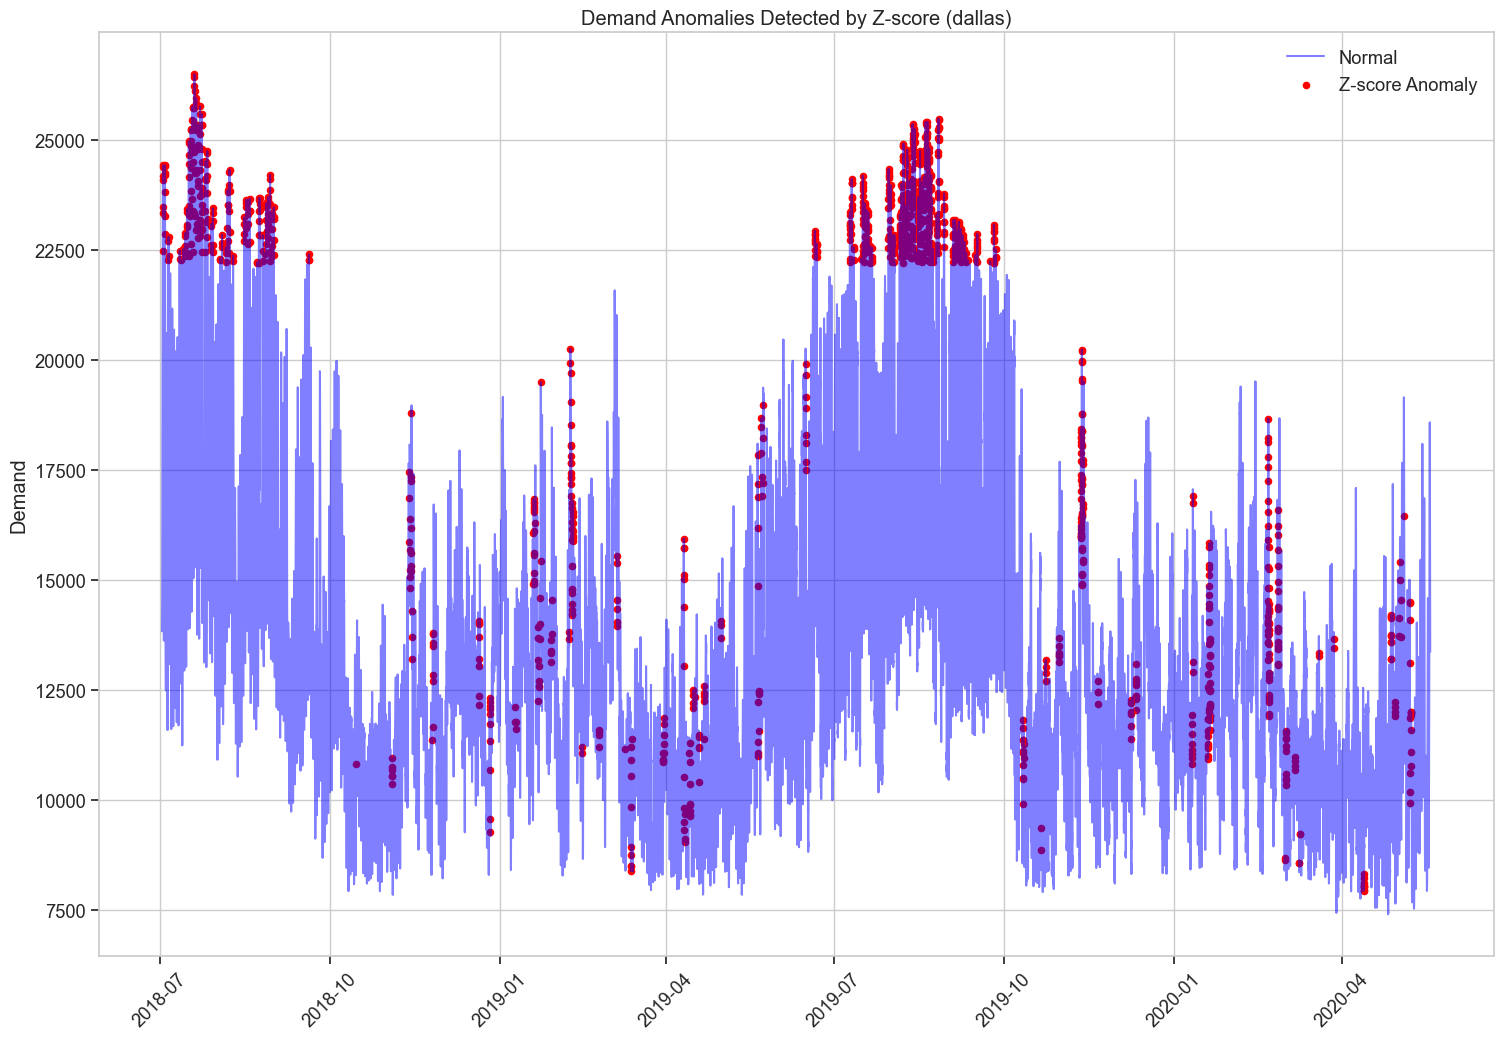

In [34]:
plt.figure(figsize=(18, 12))

sample_city = merged_data['city'].unique()[0]  
city_data = merged_data[merged_data['city'] == sample_city].sort_values('timestamp')

plt.plot(city_data['timestamp'], city_data['demand'], 'b-', alpha=0.5, label='Normal')
plt.scatter(city_data[city_data['anomaly_z']]['timestamp'], 
            city_data[city_data['anomaly_z']]['demand'], 
            color='red', label='Z-score Anomaly', s=20)
plt.title(f'Demand Anomalies Detected by Z-score ({sample_city})')
plt.ylabel('Demand')
plt.legend()
plt.xticks(rotation=45)

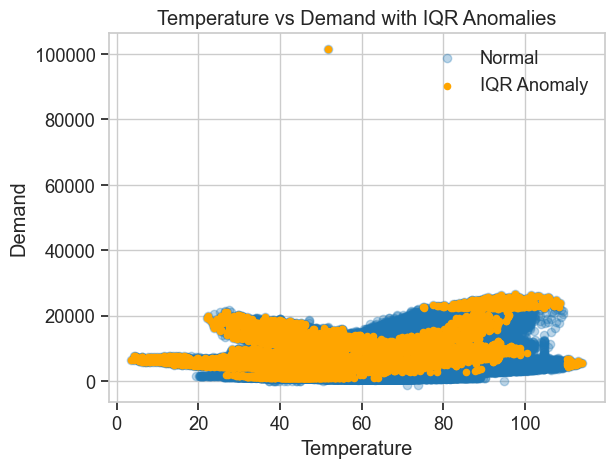

In [33]:
plt.scatter(merged_data['temperature'], merged_data['demand'], alpha=0.3, label='Normal')
plt.scatter(merged_data[merged_data['anomaly_iqr']]['temperature'], 
            merged_data[merged_data['anomaly_iqr']]['demand'], 
            color='orange', label='IQR Anomaly', s=20)
plt.title('Temperature vs Demand with IQR Anomalies')
plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.legend()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'nyc'),
  Text(1, 0, 'dallas'),
  Text(2, 0, 'philadelphia'),
  Text(3, 0, 'san_antonio'),
  Text(4, 0, 'seattle'),
  Text(5, 0, 'houston'),
  Text(6, 0, 'la'),
  Text(7, 0, 'san_jose'),
  Text(8, 0, 'phoenix'),
  Text(9, 0, 'san_diego')])

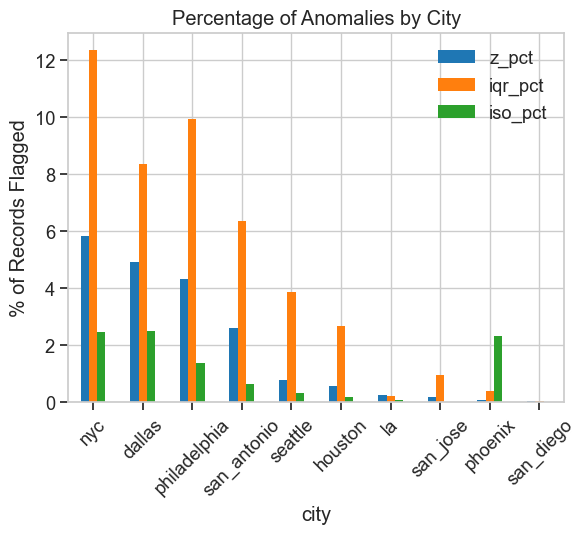

In [32]:
anomaly_by_city = merged_data.groupby('city').agg(
    total_records=('demand', 'count'),
    z_anomalies=('anomaly_z', 'sum'),
    iqr_anomalies=('anomaly_iqr', 'sum'),
    iso_anomalies=('anomaly_iso', 'sum')
).reset_index()

anomaly_by_city['z_pct'] = anomaly_by_city['z_anomalies'] / anomaly_by_city['total_records'] * 100
anomaly_by_city['iqr_pct'] = anomaly_by_city['iqr_anomalies'] / anomaly_by_city['total_records'] * 100
anomaly_by_city['iso_pct'] = anomaly_by_city['iso_anomalies'] / anomaly_by_city['total_records'] * 100

anomaly_by_city.sort_values('z_pct', ascending=False).plot(
    x='city', y=['z_pct', 'iqr_pct', 'iso_pct'], 
    kind='bar', ax=plt.gca()
)
plt.title('Percentage of Anomalies by City')
plt.ylabel('% of Records Flagged')
plt.xticks(rotation=45)

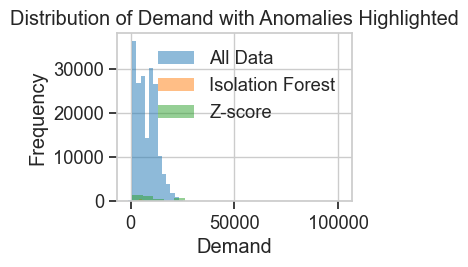

In [26]:
plt.subplot(2, 2, 4)
plt.hist(merged_data['demand'], bins=50, alpha=0.5, label='All Data')
plt.hist(merged_data[merged_data['anomaly_iso']]['demand'], bins=20, alpha=0.5, label='Isolation Forest')
plt.hist(merged_data[merged_data['anomaly_z']]['demand'], bins=20, alpha=0.5, label='Z-score')
plt.title('Distribution of Demand with Anomalies Highlighted')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

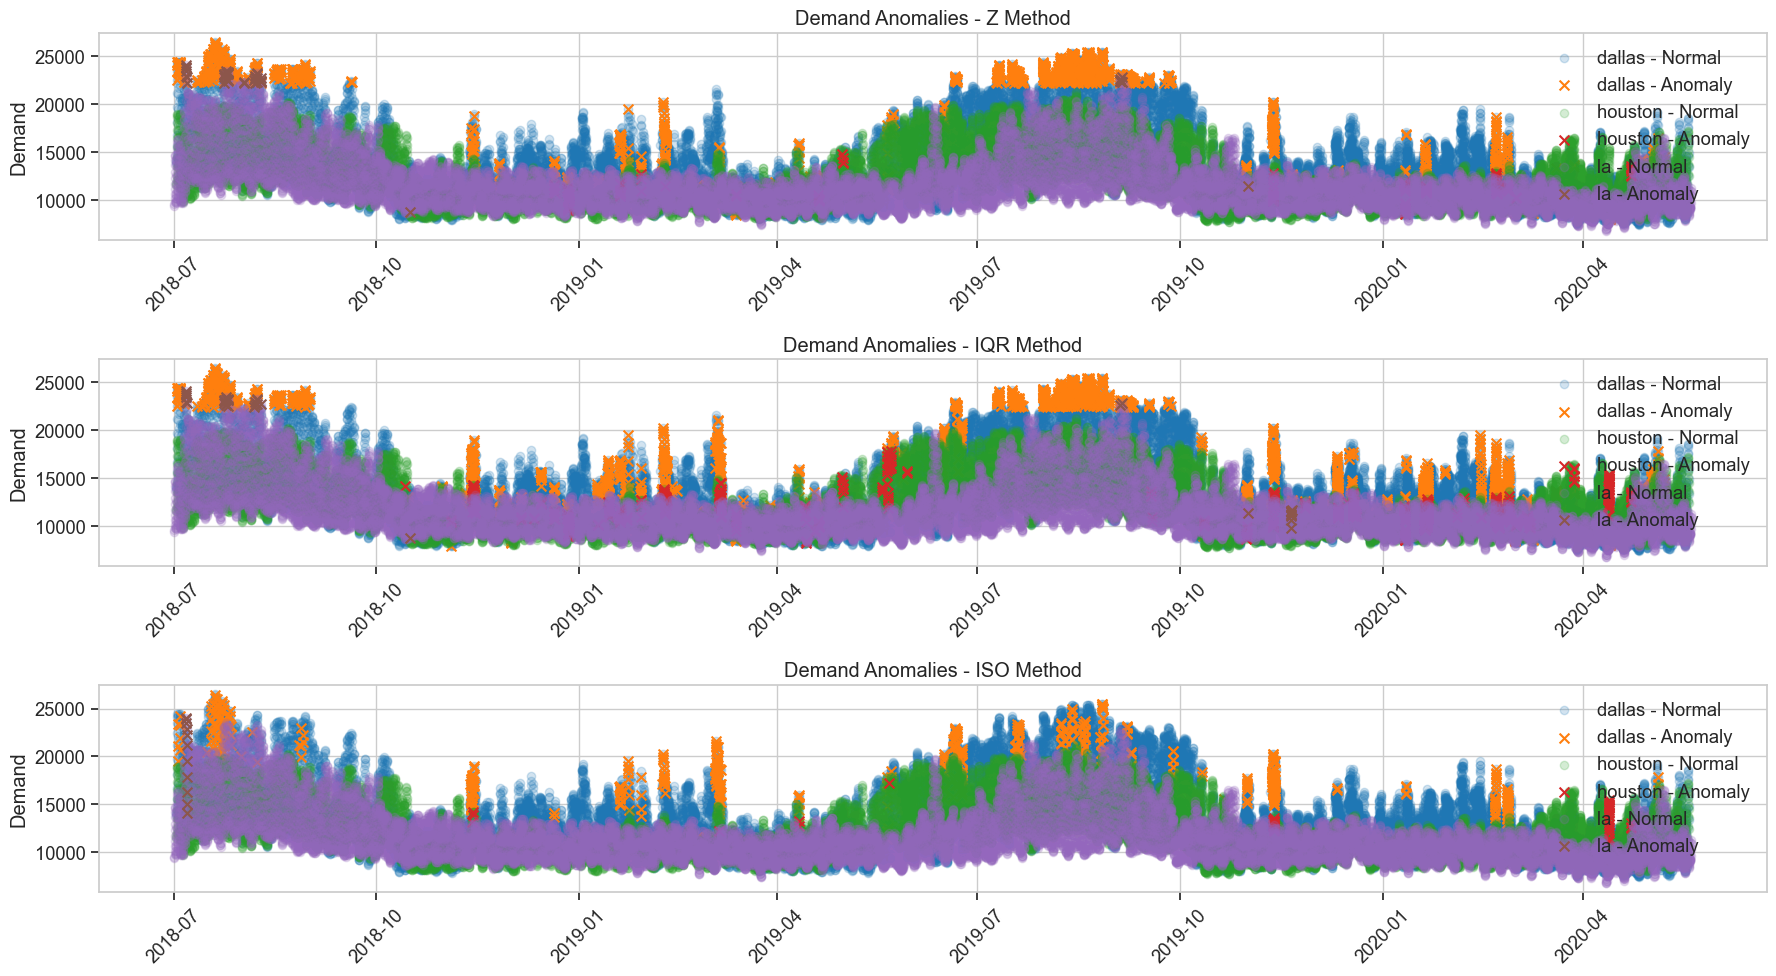

In [27]:
plt.figure(figsize=(18, 10))
for i, method in enumerate(['anomaly_z', 'anomaly_iqr', 'anomaly_iso']):
    plt.subplot(3, 1, i+1)
    for city in merged_data['city'].unique()[:3]:  # Limit to first 3 cities for clarity
        city_data = merged_data[merged_data['city'] == city]
        anomaly_data = city_data[city_data[method]]
        plt.scatter(city_data['timestamp'], city_data['demand'], 
                   alpha=0.2, label=f'{city} - Normal')
        plt.scatter(anomaly_data['timestamp'], anomaly_data['demand'], 
                   marker='x', s=50, label=f'{city} - Anomaly')
    
    plt.title(f'Demand Anomalies - {method.replace("anomaly_", "").upper()} Method')
    plt.ylabel('Demand')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 7. Output Processed Datasets

We save the processed datasets for downstream clustering and forecasting.

- `processed/load_data.csv`: Main processed dataset
- `processed/daily_data.csv`: Daily summary
- `processed/weekly_data.csv`: Weekly summary
- `processed/clean_merged_data.csv`: Clean merged data before anomaly handling

These outputs are ready for use in clustering and forecasting notebooks.

In [28]:
os.makedirs(os.path.join(dataset_path, "processed"), exist_ok=True)
merged_data.to_csv(os.path.join(dataset_path, "processed", "load_data.csv"), index=False)
daily_summary.to_csv(os.path.join(dataset_path, "processed", "daily_data.csv"), index=False)
weekly_summary.to_csv(os.path.join(dataset_path, "processed", "weekly_data.csv"), index=False)
merged_data.to_csv(os.path.join(dataset_path, "processed", "clean_merged_data.csv"), index=False)

print("Processed datasets saved.")

Processed datasets saved.


---

**Summary:**
Data is merged on canonical city names and timestamps using an inner join, ensuring city-specific matching and data integrity. All key preprocessing steps are documented and the resulting datasets are ready for clustering and forecasting.